In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsscn7/RSSCN7-master/README.md
/kaggle/input/rsscn7/RSSCN7-master/eForest/e315.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e121.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e308.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e145.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e391.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e313.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e380.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e104.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e246.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e129.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e304.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e201.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e084.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e353.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e358.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e016.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e065.jpg
/kaggle/input/rsscn7/RSSCN7-master/eForest/e386.jpg
/kaggle/input/rsscn

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import random 
import cv2

import keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers
from keras.models import Sequential
from pathlib import Path

In [9]:
base_path=Path("/kaggle/input/rsscn7/RSSCN7-master")

In [10]:
! pip install split-folders

In [12]:
import pathlib
import splitfolders
splitfolders.ratio(base_path, output='Main_data', seed=123, ratio=(0.80, 0, 0.2),
                  group_prefix=None)

Copying files: 2800 files [00:30, 91.40 files/s] 


In [13]:
train_path = "/kaggle/working/Main_data/train"
test_path = "/kaggle/working/Main_data/test"

In [14]:
labels = {


              0 : 'aGrass',
              1 : 'bField',
              2 : 'cIndustry',
              3 : 'dRiverLake',
              4 : 'eForest',
              5 : 'fResident',
              6 : 'gParking'
    }

In [17]:
l=list(labels.values())
l

['aGrass',
 'bField',
 'cIndustry',
 'dRiverLake',
 'eForest',
 'fResident',
 'gParking']

In [18]:
train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(directory=train_path,  
                                     classes = ['aGrass',
                                                 'bField',
                                                 'cIndustry',
                                                 'dRiverLake',
                                                 'eForest',
                                                 'fResident',
                                                 'gParking'],
                                     subset='training',
                                     batch_size=10)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path, 
                                          classes = ['aGrass',
                                                 'bField',
                                                 'cIndustry',
                                                 'dRiverLake',
                                                 'eForest',
                                                 'fResident',
                                                 'gParking'],
                                          subset='validation',
                                          batch_size=10)
                
test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path, 
                                        classes = ['aGrass',
                                                 'bField',
                                                 'cIndustry',
                                                 'dRiverLake',
                                                 'eForest',
                                                 'fResident',
                                                 'gParking'],
                                         batch_size=10, 
                                         shuffle=False)

Found 2016 images belonging to 7 classes.
Found 224 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [29]:
EPOCHS = 10
BATCH_SIZE = 32

In [33]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

In [34]:
IMG_SIZE = 224
n_classes = 7

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x4 = cbam_block(x3)
x5 = layers.BatchNormalization(axis=-1)(x4)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                   activation='relu', padding = 'same')(x6)
x8 = cbam_block(x7)
x9 = layers.BatchNormalization(axis=-1)(x8)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                    activation='relu', padding = 'same')(x10)
x12 = cbam_block(x11) 
x13 = layers.BatchNormalization(axis=-1)(x12)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x14)
x16 = cbam_block(x15)
x17 = layers.BatchNormalization(axis=-1)(x16)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)   


model_CBAM = tf.keras.Model(inp, y)

In [35]:
model_CBAM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   loss='categorical_crossentropy', 
                   metrics=METRICS)

In [36]:
history_CBAM = model_CBAM.fit(x=train_batches,
                              validation_data=validation_batches,
                              steps_per_epoch=len(train_batches),
                              validation_steps=len(validation_batches),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE, 
                              verbose=2)

Epoch 1/10
202/202 - 28s - loss: 1.4109 - accuracy: 0.5404 - precision: 0.6042 - recall: 0.4503 - auc: 0.8720 - val_loss: 2.1440 - val_accuracy: 0.1429 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5031 - 28s/epoch - 137ms/step
Epoch 2/10
202/202 - 17s - loss: 0.8271 - accuracy: 0.6875 - precision: 0.7380 - recall: 0.6176 - auc: 0.9430 - val_loss: 3.1280 - val_accuracy: 0.1429 - val_precision: 0.1429 - val_recall: 0.1429 - val_auc: 0.4920 - 17s/epoch - 84ms/step
Epoch 3/10
202/202 - 17s - loss: 0.6513 - accuracy: 0.7619 - precision: 0.8007 - recall: 0.7133 - auc: 0.9632 - val_loss: 1.6479 - val_accuracy: 0.5045 - val_precision: 0.5667 - val_recall: 0.4554 - val_auc: 0.8287 - 17s/epoch - 85ms/step
Epoch 4/10
202/202 - 16s - loss: 0.4996 - accuracy: 0.8244 - precision: 0.8482 - recall: 0.7956 - auc: 0.9772 - val_loss: 0.9628 - val_accuracy: 0.6295 - val_precision: 0.6754 - val_recall: 0.5759 - val_auc: 0.9286 - 16s/epoch - 82ms/step
Epoch 5/10
202/202 - 17s - loss: 0.

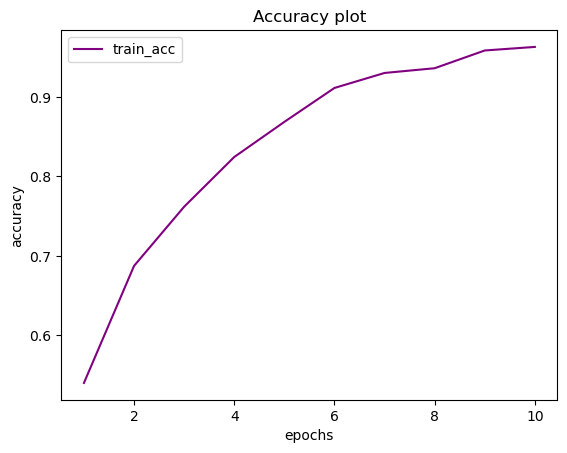

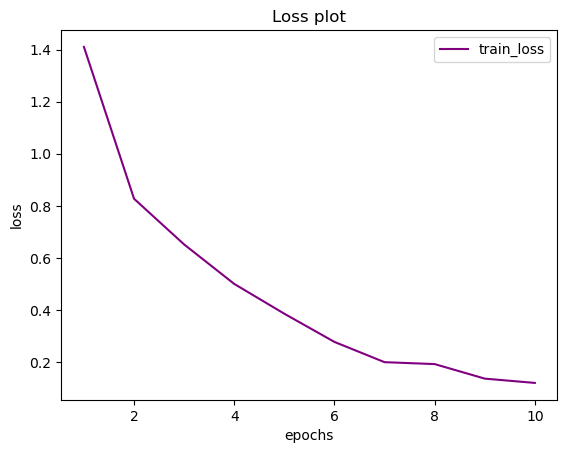

In [39]:
epochs= range(1, len(history_CBAM .history["accuracy"])+1)

plt.plot(epochs, history_CBAM .history["accuracy"], color="purple")
#plt.plot(epochs, history_CBAM .history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc"])
plt.show()

plt.plot(epochs, history_CBAM .history["loss"], color="purple")
#plt.plot(epochs, history_CBAM .history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss"])
plt.show()

In [42]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [44]:
train_batches.class_indices

{'aGrass': 0,
 'bField': 1,
 'cIndustry': 2,
 'dRiverLake': 3,
 'eForest': 4,
 'fResident': 5,
 'gParking': 6}

In [55]:
image_path = '/kaggle/input/rsscn7/RSSCN7-master/eForest/e001.jpg'
img = image.load_img(image_path, target_size=(224,224,3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model_CBAM.predict(img_array)
predicted_class_index = np.argmax(prediction)
class_labels = train_batches.class_indices
predicted_class_label = list(class_labels.keys())[predicted_class_index]

print('Predicted class:', predicted_class_label)

1/1 [==============================] - 0s 29ms/step
Predicted class: eForest


In [56]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

In [60]:
predictions = np.argmax(model_CBAM.predict(test_batches), axis=1)

cm = confusion_matrix(test_batches.labels, predictions)
clr = classification_report(test_batches.labels, predictions, target_names=test_batches.class_indices, zero_division=0)

56/56 [==============================] - 3s 42ms/step


In [61]:
print(clr)

              precision    recall  f1-score   support

      aGrass       0.72      0.79      0.75        80
      bField       0.80      0.79      0.79        80
   cIndustry       0.48      0.79      0.60        80
  dRiverLake       0.79      0.81      0.80        80
     eForest       0.97      0.72      0.83        80
   fResident       0.87      0.51      0.65        80
    gParking       0.68      0.62      0.65        80

    accuracy                           0.72       560
   macro avg       0.76      0.72      0.72       560
weighted avg       0.76      0.72      0.72       560



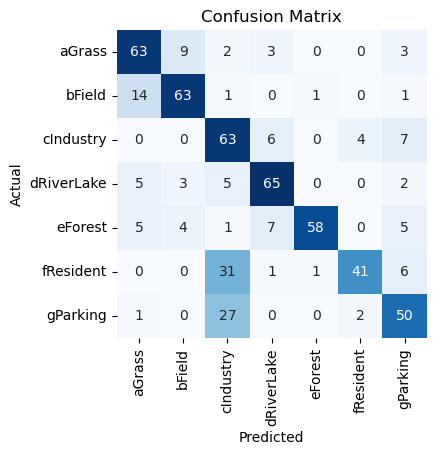

In [64]:
import seaborn as sns
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(7) + 0.5, labels=test_batches.class_indices, rotation=90)
plt.yticks(ticks=np.arange(7) + 0.5, labels=test_batches.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()